In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from pycmqlib3.strategy.signal_repo import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# define product groups and start times

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [5]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2024,2,8)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)

cdates = pd.date_range(start=start_date, end=end_date, freq='D')
bdates = pd.bdate_range(start=start_date, end=end_date, freq='C', holidays=misc.CHN_Holidays)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2024-02-02  8045.0    AP405 -10127.0  2024-05-17  8128.0  8036.0  24293.0   
2024-02-05  8000.0    AP405   2048.0  2024-05-17  8062.0  7965.0  24293.0   
2024-02-06  8014.0    AP405  -5137.0  2024-05-17  8058.0  7974.0  24293.0   
2024-02-07  8076.0    AP405  -3942.0  2024-05-17  8093.0  8015.0  24293.0   
2024-02-08  8052.0    AP405 -11656.0  2024-05-17  8130.0  8038.0  24293.0   

product                                                                  \
code                                                c2                    
field         open openInterest shift   volume   close contract diff_oi   
date                                                                      
2024-02-02  8097.0      90747.0   0.0  48770.0  8219.0    AP410   -88.0   
2024-02-05  8062.0      92795.0   0.0  48935.0  8152.0    AP410    94.0   
2024-02-06  7976.0      87659.0   0.0  36976.0  8123.0    AP410   125.0   
2024-02-07  8052.0      83717.0   0.0  48115.0  8100.0    AP410   -11.0   
2024-02-08  8080.0      72061.0   0.0  41676.0  8138.0    AP410    17.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2024-02-02  2024-10-21  8255.0  8190.0  24298.0  8220.0       4175.0   0.0   
2024-02-05  2024-10-21  8215.0  8140.0  24298.0  8215.0       4269.0   0.0   
2024-02-06  2024-10-21  8169.0  8116.0  24298.0  8140.0       4394.0   0.0   
2024-02-07  2024-10-21  8158.0  8100.0  24298.0  8118.0       4383.0   0.0   
2024-02-08  2024-10-21  8199.0  8119.0  24298.0  8124.0       4400.0   0.0   

product                  CF                                                  \
code                     c1                                                   
field       volume    close contract  diff_oi      expiry     high      low   
date                                                                          
2024-02-02   564.0  15990.0    CF405 -11681.0  2024-05-17  16100.0  15920.0   
2024-02-05   670.0  16025.0    CF405  -9267.0  2024-05-17  16080.0  15955.0   
2024-02-06   968.0  16055.0    CF405   2606.0  2024-05-17  16115.0  15990.0   
2024-02-07  1103.0  15985.0    CF405 -23812.0  2024-05-17  16100.0  15950.0   
2024-02-08   614.0  16025.0    CF405 -11601.0  2024-05-17  16165.0  15990.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2024-02-02  24293.0  16000.0     574096.0   0.0  303595.0  16120.0    CF409   
2024-02-05  24293.0  15970.0     564829.0   0.0  240747.0  16145.0    CF409   
2024-02-06  24293.0  16045.0     567435.0   0.0  211573.0  16170.0    CF409   
2024-02-07  24293.0  16070.0     543623.0   0.0  206362.0  16125.0    CF409   
2024-02-08  24293.0  15990.0     532022.0   0.0  207012.0  16170.0    CF409   

product                                                             \
code                                                                 
field      diff_oi      expiry     high      low      mth     open   
date                                                                 
2024-02-02 -1673.0  2024-09-13  16240.0  16055.0  24297.0  16140.0   
2024-02-05 -1291.0  2024-09-13  16195.0  16090.0  24297.0  16115.0   
2024-02-06   215.0  2024-09-13  16230.0  16120.0  24297.0  16150.0   
2024-02-07  1

In [6]:
asset_pairs = [('i', 'rb'), ('i', 'hc'), ('i', 'j'), ('j', 'jm'),]
beta_ret_dict = {}
betas_dict = {}
for trade_asset, index_asset in asset_pairs:
    asset_df = df[[(index_asset, 'c1', 'close'), (trade_asset, 'c1', 'close')]].copy(deep=True).droplevel([1,2], axis=1)
    asset_df = asset_df.dropna(subset=[trade_asset]).ffill()

    for asset in asset_df:
        asset_df[f'{asset}_pct'] = asset_df[asset].pct_change().rolling(5).mean()
    asset_df['beta'] = asset_df[f'{index_asset}_pct'].rolling(244).cov(asset_df[f'{trade_asset}_pct'])/asset_df[f'{index_asset}_pct'].rolling(244).var()
    key = '_'.join([trade_asset, index_asset])
    asset_df[key] = asset_df[trade_asset].pct_change() - asset_df['beta'] * asset_df[index_asset].pct_change().fillna(0)
    beta_ret_dict[key] = asset_df[key].dropna()
    betas_dict[key] = asset_df['beta']


# funda data loading/processing

In [7]:
from pycmqlib3.utility.spot_idx_map import *

data_df = dbaccess.load_codes_from_edb(index_map.keys(), source='ifind', column_name='index_code')
data_df = data_df.rename(columns=index_map)
data_df

index_code  usgg2yr  usgg10yr  usggt10yr  libor3m       dxy  ted_spd    vix  \
date                                                                          
1970-02-18      NaN      7.12        NaN      NaN       NaN      NaN    NaN   
1970-02-19      NaN      7.09        NaN      NaN       NaN      NaN    NaN   
1970-02-20      NaN      7.12        NaN      NaN       NaN      NaN    NaN   
1970-02-24      NaN      7.14        NaN      NaN       NaN      NaN    NaN   
1970-02-25      NaN      7.04        NaN      NaN       NaN      NaN    NaN   
...             ...       ...        ...      ...       ...      ...    ...   
2024-02-08     4.46      4.15       1.91  5.56296  104.1405  0.12296  12.79   
2024-02-09     4.48      4.17       1.92  5.57066  104.0893  0.13066  12.93   
2024-02-12     4.46      4.17       1.93  5.56814  104.1446  0.13814  13.93   
2024-02-13     4.64      4.31       2.02  5.56860  104.8646  0.11860  15.85   
2024-02-14     4.56      4.27       1.97  5.58729  104.7252  0.15729  14.38   

index_code   vvix  vxeem    vxd    vxn  usgg10yr_2yr_spd  usggbe5  dr007_cn  \
date                                                                          
1970-02-18    NaN    NaN    NaN    NaN               NaN      NaN       NaN   
1970-02-19    NaN    NaN    NaN    NaN               NaN      NaN       NaN   
1970-02-20    NaN    NaN    NaN    NaN               NaN      NaN       NaN   
1970-02-24    NaN    NaN    NaN    NaN               NaN      NaN       NaN   
1970-02-25    NaN    NaN    NaN    NaN               NaN      NaN       NaN   
...           ...    ...    ...    ...               ...      ...       ...   
2024-02-08  83.07  16.56  11.52  16.96             -0.31     2.28    1.7829   
2024-02-09  81.94  16.17  11.44  16.85             -0.31     2.28    1.8500   
2024-02-12  84.63  16.46  11.44  18.10             -0.29     2.27       NaN   
2024-02-13  93.19  16.84  11.44  19.50             -0.33     2.33       NaN   
2024-02-14  83.17  16.04  11.44  18.25             -0.29     2.34       NaN   

index_code  fr007_cn  fdr007_cn  usdcny_on  usdcny_1m  cnh_hibor_1m  \
date                                                                  
1970-02-18       NaN        NaN        NaN        NaN           NaN   
1970-02-19       NaN        NaN        NaN        NaN           NaN   
1970-02-20       NaN        NaN        NaN        NaN           NaN   
1970-02-24       NaN        NaN        NaN        NaN           NaN   
1970-02-25       NaN        NaN        NaN        NaN           NaN   
...              ...        ...        ...        ...           ...   
2024-02-08      1.80       1.80      -0.06      -1.90       3.22409   
2024-02-09      1.85       1.85      -0.85      -1.93           NaN   
2024-02-12       NaN        NaN        NaN        NaN           NaN   
2024-02-13       NaN        NaN        NaN        NaN           NaN   
2024-02-14       NaN        NaN        NaN        NaN           NaN   

index_code  shibor_1m  shibor_3m  shibor_1y  r007_cn  csi300_idx  csi500_idx  \
date                                                                           
1970-02-18        NaN        NaN        NaN      NaN         NaN         NaN   
1970-02-19        NaN        NaN        NaN      NaN         NaN         NaN   
1970-02-20        NaN        NaN        NaN      NaN         NaN         NaN   
1970-02-24        NaN        NaN        NaN      NaN         NaN         NaN   
1970-02-25        NaN        NaN        NaN      NaN         NaN         NaN   
...               ...        ...        ...      ...         ...         ...   
2024-02-08      2.213      2.334      2.397     1.90   3364.9297   5150.2288   
2024-02-09      2.210      2.330      2.396     1.85         NaN         NaN   
2024-02-12        NaN        NaN        NaN      NaN         NaN         NaN   
2024-02-13        NaN        NaN        NaN      NaN         NaN         NaN   
2024-02-14        NaN        NaN        NaN      NaN        

In [8]:
spot_df = process_spot_df(data_df, adjust_time=True)
spot_df = spot_df.dropna(how='all').copy(deep=True)
spot_df['flat_strct'] = (spot_df['plate_8mm'] + spot_df['hrc_sh'] + spot_df['crc_sh'])/3 - (spot_df['hsec_400x200'] + spot_df['channel_16'] + spot_df['ibeam_25'])/3


In [ ]:
# spot_df = spot_df.reindex(index=pd.date_range(spot_df.index[0], spot_df.index[-1], freq='D', name='date'))

# for col in []:
#     spot_df[col] = spot_df.shift(3)

# spot_df = spot_df.dropna(how='all')

# feature study

In [36]:
vol_win=20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
empiric_assets = [
    'i', 'rb', 'hc', 'j', # 'jm', 
    #'v', 'SF', 'SM', 'al', 'FG'
] #

vol_df = get_asset_vols(df, empiric_assets, vol_win=vol_win, vol_type='pct_chg')
df_pxchg = df.loc[:, df.columns.get_level_values(0).isin(empiric_assets) 
                   & (df.columns.get_level_values(1)=='c1') 
                   & (df.columns.get_level_values(2)=='close')
                  ].droplevel([1, 2], axis=1).dropna(how='all').pct_change()

# ## for beta neutral
# empiric_assets = ['i_rb', 'i_hc', 'j_jm']
# df_pxchg = pd.DataFrame(index=beta_ret_dict[empiric_assets[0]].index, columns=empiric_assets)
# vol_df = pd.DataFrame(index=beta_ret_dict[empiric_assets[0]].index, columns=empiric_assets)
# for asset in empiric_assets:
#     df_pxchg[asset] = beta_ret_dict[asset].dropna()
#     vol_df[asset] = df_pxchg[asset].rolling(vol_win).std()

customerized signal

sharpe       1.094742
sharpe_6m    0.307849
sharpe_1y   -0.227259
sharpe_2y    0.398855
sharpe_3y    1.264458
sharpe_4y    1.650886
sharpe_5y    1.012275
sharpe_6y    1.138696
sharpe_7y    1.239892
sharpe_8y    1.137120
sharpe_9y    1.114039
Name: total, dtype: float64
product           i        rb        hc         j
sharpe     1.023313  0.924315  1.090204  0.822621
sharpe_6m  0.757178 -0.202905  0.176576  0.372174
sharpe_1y  0.285038 -0.420360 -0.217553 -0.427428
sharpe_2y  0.553946  0.289594  0.331727  0.284279
sharpe_3y  1.296160  1.304143  1.144478  0.760368
sharpe_4y  1.601413  1.547673  1.527421  1.157770
sharpe_5y  1.114169  0.904677  1.004288  0.555905
sharpe_6y  1.176052  1.019157  1.006514  0.797384
sharpe_7y  1.183417  1.025392  1.138040  1.006327
sharpe_8y  1.071703  0.912657  1.021721  1.007423
sharpe_9y  1.111718  0.883084  0.984462  0.958371
         pnl_per_trade   turnover
product                          
i            90.333076  17.580943
rb           52.800427  17.6

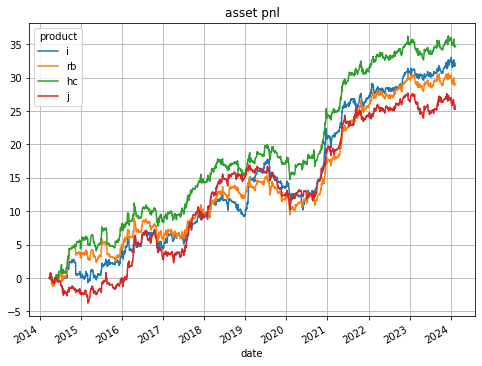

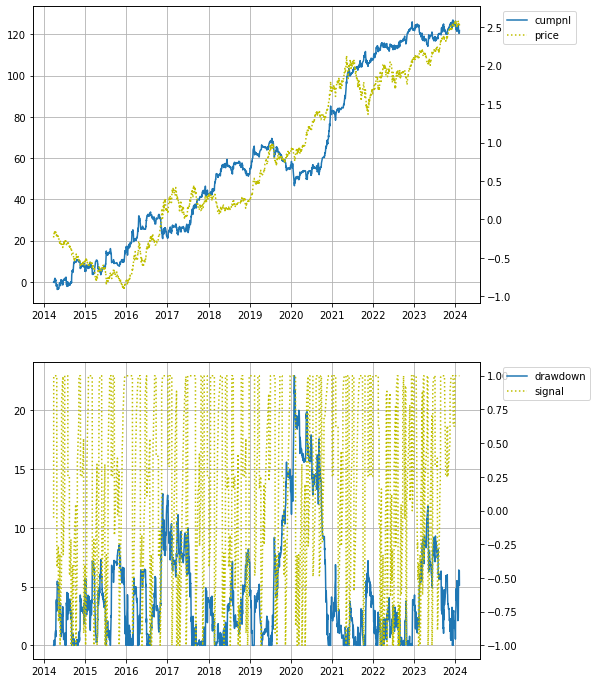

In [78]:
cutoff='2012-01-01'
feature='io_invdays_imp_mill(64)'
param_rng = [20, 40, 2]
signal_cap = None
signal_func = 'qtl'
chg_func = 'diff'
bullish = True
#freq='W-Fri'

feature_ts = spot_df[feature].reindex(index=cdates).shift(1).ffill().reindex(index=df.index)
#feature_ts = spot_df[feature].reindex(index=cdates).shift(1).ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill().dropna()
#feature_ts = spot_df[feature].dropna()

#label_func = lunar_label
# label_args = {}
# # label_func = calendar_label
# # label_args = {'anchor_date': {'month': 1, 'day': 1}}
# #group_col = 'label_wk'
#group_col = 'label_day'
#feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col=group_col, func=chg_func)[feature]

#feature_ts = feature_ts.ffill().reindex(index=df.index)
#feature_ts = feature_ts.diff()
signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
# signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10)
# signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
# signal_ts = feature_ts

if not bullish:
    signal_ts = -signal_ts
    
signal_ts = signal_ts.reindex(index=cdates).ffill().reindex(index=df_pxchg.index).dropna()[cutoff:]
signal_ts = signal_ts.rolling(1).mean()

signal_df = pd.DataFrame(dict([(asset, signal_ts) for asset in empiric_assets]))

holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1.0, asset_scaling=False)
bt_metrics = MetricsBase(holdings=holding[empiric_assets][cutoff:],
                         returns=df_pxchg[empiric_assets][cutoff:], shift_holdings=1)

pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors)

print(pnl_stats['sharpe'])
print(pnl_stats['asset_sharpe_stats'])

print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))

pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
plt.grid()
plt.title('asset pnl')

plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_ts, asset_price=df_pxchg[empiric_assets[0]].cumsum(), figsize=(8, 12))

standard signal

In [45]:
cutoff='2012-01-01'

feature_setup = {
    'io_removal_lvl': [('i', 'rb', 'hc', 'j', 'jm'), 
                       ('io_removal_41ports', 'qtl', [20, 40, 2], '', 'diff', True, 'price', '')],
    'io_removal_lyoy': [('i', 'rb', 'hc', 'j', 'jm'), 
                        ('io_removal_41ports', 'qtl', [8, 12], 'lunar_yoy_day', 'diff', True, 'W-Fri', '')],
    'io_removal_wow': [('i', 'rb', 'hc', 'j', 'jm'), 
                       ('io_removal_41ports', 'zscore', [48, 53], 'df1', 'diff', True, 'W-Fri', '')],
    'io_millinv_lvl': [('i', 'rb', 'hc', 'j', 'jm'), 
                       ('io_inv_mill(64)', 'qtl', [20, 40, 2], '', 'diff', True, 'price', '')],
    'io_millinv_lyoy': [('i', 'rb', 'hc', 'j', 'jm'), 
                        ('io_inv_mill(64)', 'qtl', [2, 4], 'lunar_yoy_day', 'diff', True, 'W-Fri', '')],
    'io_invdays_lvl': [('i', 'rb', 'hc', 'j', 'jm'), 
                       ('io_invdays_imp_mill(64)', 'qtl', [20, 40, 2], '', 'pct_change', True, 'price', '')],
    'io_invdays_lyoy': [('i', 'rb', 'hc', 'j', 'jm'), 
                        ('io_invdays_imp_mill(64)', 'qtl', [2, 4], 'lunar_yoy_day', 'pct_change', True, 'W-Fri', '')],
}


feature_names = [
    ('io_removal_lvl', 1.0),
    ('io_removal_lyoy', 1.0),
    #('io_removal_wow', 1.0),
    ('io_millinv_lyoy', 1.0),
    #('io_millinv_lvl', 1.0),
    ('io_invdays_lyoy', 1.0),
    ('io_invdays_lvl', 1.0),
    ('strip_hsec_lvl_mid', 1.0),
    ('steel_margin_lvl_fast', 1.0),
]

feature_dict = {}
signal_dict = {}
signal_cap= None #[-2, 2]
sig_ts_list = []

for feature_name, weight in feature_names:
    signal_assets = feature_setup[feature_name][0]
    feature, signal_func, param_rng, proc_func, chg_func, bullish, freq, post_func = feature_setup[feature_name][1]
    
    if freq == 'price':
        feature_ts = spot_df[feature].reindex(index=cdates).ffill().reindex(index=bdates)
    elif len(freq) > 0:
        feature_ts = spot_df[feature].reindex(index=cdates).ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq))
    else:
        feature_ts = spot_df[feature].dropna()

    if 'yoy' in proc_func:
        if 'lunar' in proc_func:
            label_func = lunar_label
            label_args = {}
        else:
            label_func = calendar_label
            label_args = {'anchor_date': {'month': 1, 'day': 1}}
        if '_wk' in proc_func:
            group_col = 'label_wk'
        else:
            group_col = 'label_day'
        feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
    elif 'df' in proc_func:
        n_diff = int(proc_func[2:])
        feature_ts = getattr(feature_ts, chg_func)(n_diff)
    
    feature_dict[feature_name] = feature_ts
    
    if signal_func == 'seasonal_score_w':
        signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
    elif signal_func == 'seasonal_score_d':
        signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
    elif len(signal_func)>0:
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
    else:
        signal_ts = feature_ts.reindex(index=df.index).ffill()

    if not bullish:
        signal_ts = -signal_ts
    signal_ts = signal_ts.reindex(index=cdates).ffill().reindex(index=df_pxchg.index)
    signal_dict[feature_name] = signal_ts
    sig_ts_list.append(signal_ts * weight)

signal_ts = pd.concat(sig_ts_list, axis=1).sum(axis=1)
signal_dict['combo'] = signal_ts

In [ ]:
#feature_dict['millinv_lyoy'].dropna()['2019-12-15':].head(20)
#signal_ts['2020-01-01':].head(40)

signal=io_removal_lvl
sharpe       0.975190
sharpe_6m    2.339326
sharpe_1y    1.350463
sharpe_2y    1.250283
sharpe_3y    1.354347
sharpe_4y    0.866892
sharpe_5y    0.666556
sharpe_6y    0.872761
sharpe_7y    0.975190
sharpe_8y    0.975190
sharpe_9y    0.975190
Name: total, dtype: float64
std       0.495767
std_6m    0.469221
std_1y    0.521265
std_2y    0.515148
std_3y    0.489753
std_4y    0.505436
std_5y    0.497841
std_6y    0.499395
std_7y    0.495767
std_8y    0.495767
std_9y    0.495767
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.393337  0.514991  0.447312  0.776146  0.820733  0.575606   
sharpe_6m  1.027478  2.817771  2.029314  2.605109  2.148597  1.058055   
sharpe_1y  0.410968  1.302881  1.568782  1.126487  0.972485  0.838177   
sharpe_2y  0.806491  0.820965  1.138059  1.028193  0.926616  0.564859   
sharpe_3y  1.116459  0.391889  0.882303  0.856942  1.102586  0.830422   
sharpe_4y  0.817607  0.179314  0.

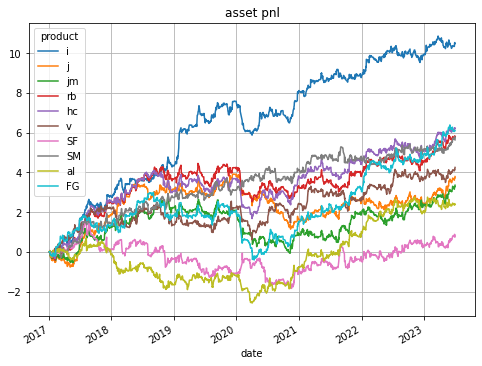

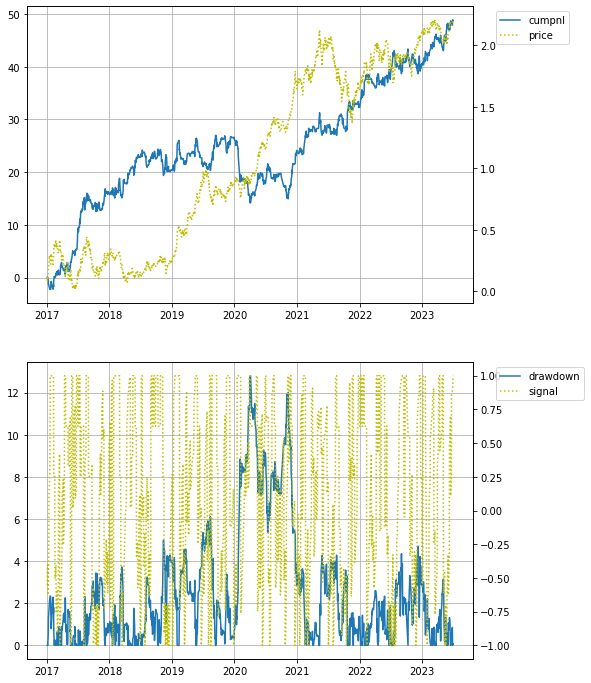

signal=io_removal_lyoy
sharpe       0.978627
sharpe_6m    1.821911
sharpe_1y    0.820919
sharpe_2y    1.556965
sharpe_3y    1.103971
sharpe_4y    1.176690
sharpe_5y    0.911035
sharpe_6y    0.931344
sharpe_7y    0.978627
sharpe_8y    0.978627
sharpe_9y    0.978627
Name: total, dtype: float64
std       0.497186
std_6m    0.555765
std_1y    0.512628
std_2y    0.516270
std_3y    0.510142
std_4y    0.495521
std_5y    0.484118
std_6y    0.501767
std_7y    0.497186
std_8y    0.497186
std_9y    0.497186
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.149454  0.470497  0.431672  0.889833  0.842573  0.952894   
sharpe_6m  1.091593  1.661571  2.123462  1.968627  1.894016  1.664615   
sharpe_1y -0.266637  0.934844  1.320674  0.727563  0.637600  0.690677   
sharpe_2y  1.253716  0.765672  1.154410  1.298895  1.068122  1.129256   
sharpe_3y  0.923281 -0.014109  0.556319  0.714129  0.638216  1.348362   
sharpe_4y  0.944603  0.252306  0

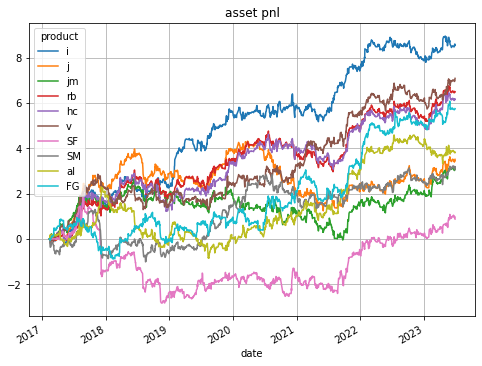

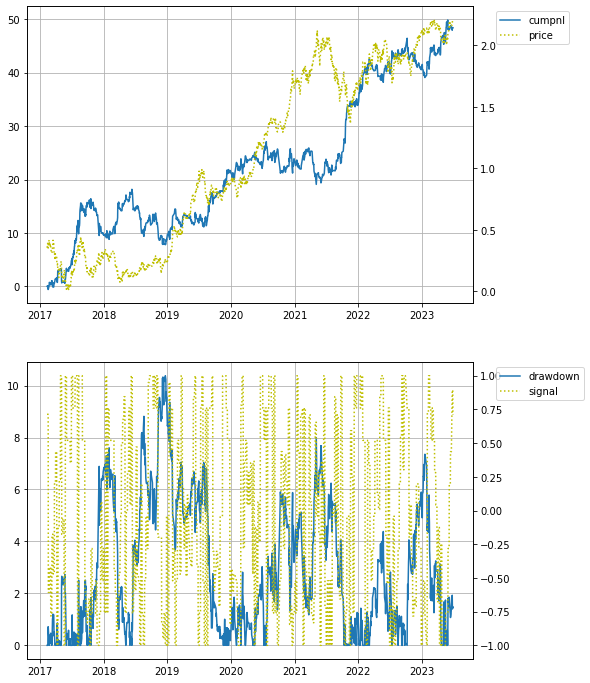

signal=io_millinv_lyoy
sharpe       1.712820
sharpe_6m    2.585955
sharpe_1y    2.959236
sharpe_2y    1.321467
sharpe_3y    1.759584
sharpe_4y    1.556628
sharpe_5y    1.546905
sharpe_6y    1.775657
sharpe_7y    1.712820
sharpe_8y    1.712820
sharpe_9y    1.712820
Name: total, dtype: float64
std       0.654720
std_6m    0.649143
std_1y    0.702124
std_2y    0.685816
std_3y    0.678512
std_4y    0.670556
std_5y    0.654547
std_6y    0.654595
std_7y    0.654720
std_8y    0.654720
std_9y    0.654720
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.583366  1.461463  1.136293  1.534141  1.804789  0.647213   
sharpe_6m  2.228780  3.108652  2.608340  2.900691  3.120276  2.034109   
sharpe_1y  2.459351  2.696933  2.588009  2.848994  2.898623  2.767581   
sharpe_2y  1.369000  1.203242  0.806937  1.551772  1.647331  0.918098   
sharpe_3y  1.983764  1.294987  0.839978  1.849733  2.042407  0.975422   
sharpe_4y  1.715069  0.963696  0

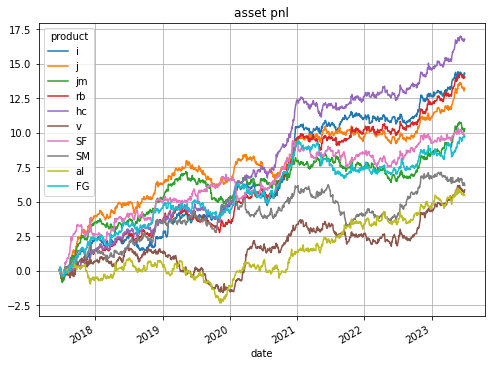

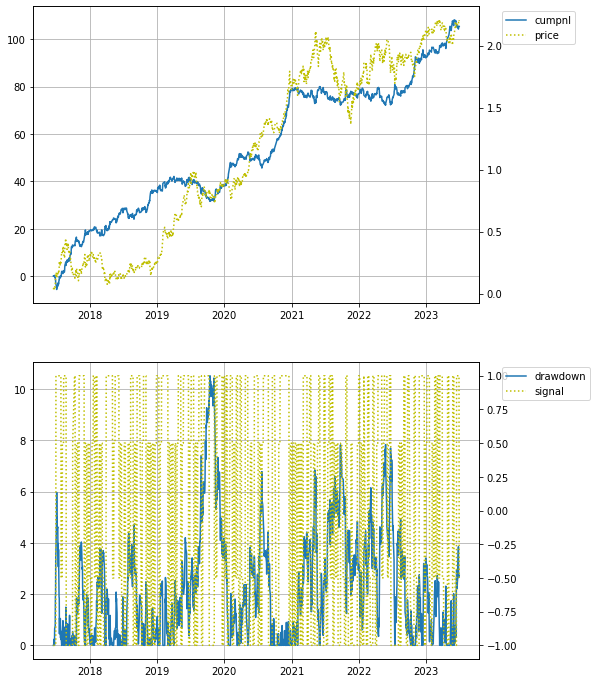

signal=io_invdays_lyoy
sharpe       1.797996
sharpe_6m    1.823742
sharpe_1y    1.875890
sharpe_2y    0.806638
sharpe_3y    1.864845
sharpe_4y    1.800762
sharpe_5y    1.781936
sharpe_6y    1.927609
sharpe_7y    1.797996
sharpe_8y    1.797996
sharpe_9y    1.797996
Name: total, dtype: float64
std       0.658193
std_6m    0.667021
std_1y    0.712732
std_2y    0.697265
std_3y    0.685245
std_4y    0.675338
std_5y    0.658437
std_6y    0.660621
std_7y    0.658193
std_8y    0.658193
std_9y    0.658193
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.389847  1.505691  1.231558  1.481238  1.738365  1.173429   
sharpe_6m  1.216303  2.344448  2.281318  1.848679  1.792250  1.928494   
sharpe_1y  1.828691  2.157424  2.033995  2.028137  1.894994  1.840111   
sharpe_2y  0.169185  1.254036  0.743667  1.110137  1.000513  1.163105   
sharpe_3y  1.688705  1.913659  1.217052  1.786121  1.863394  1.342398   
sharpe_4y  1.429003  1.479163  1

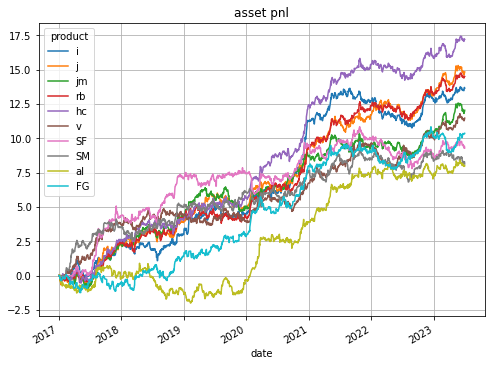

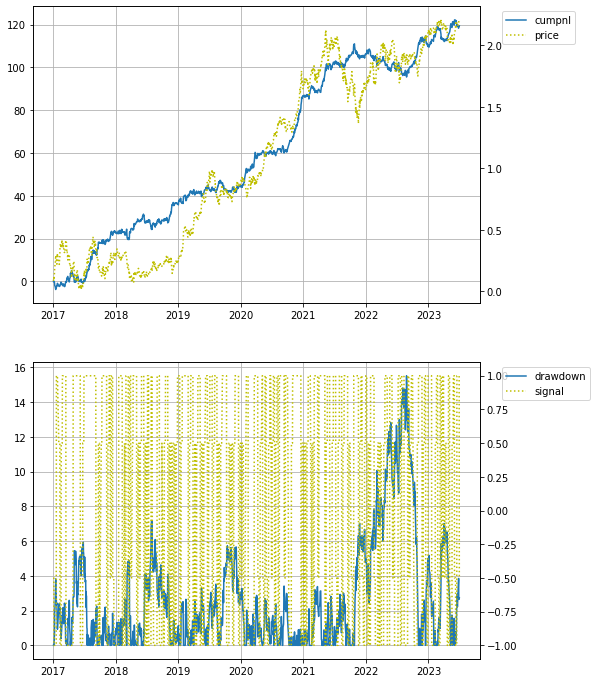

signal=io_invdays_lvl
sharpe       1.794377
sharpe_6m   -1.301222
sharpe_1y    0.273927
sharpe_2y    1.293930
sharpe_3y    2.383254
sharpe_4y    1.663897
sharpe_5y    1.572530
sharpe_6y    1.856369
sharpe_7y    1.794377
sharpe_8y    1.794377
sharpe_9y    1.794377
Name: total, dtype: float64
std       0.547916
std_6m    0.530577
std_1y    0.528969
std_2y    0.547307
std_3y    0.571907
std_4y    0.570022
std_5y    0.544432
std_6y    0.554657
std_7y    0.547916
std_8y    0.547916
std_9y    0.547916
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.245644  1.086315  1.033701  1.117256  1.208004  1.676393   
sharpe_6m -0.340491 -1.054596 -1.888815 -0.628711 -0.809132 -0.667376   
sharpe_1y  0.886483 -0.006030 -0.244994  0.770135  0.410480  0.748679   
sharpe_2y  0.791915  0.277048  0.526057  1.096494  0.761864  1.938395   
sharpe_3y  1.947159  1.367341  1.246620  1.899259  1.753393  2.305564   
sharpe_4y  1.055396  0.693856  1.

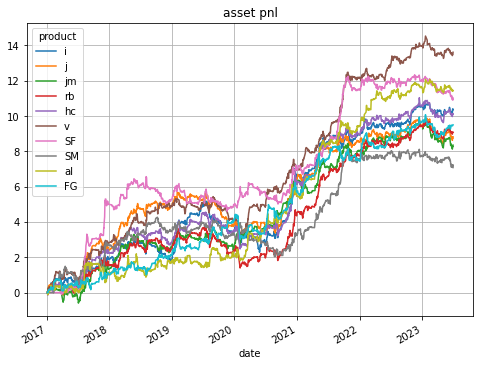

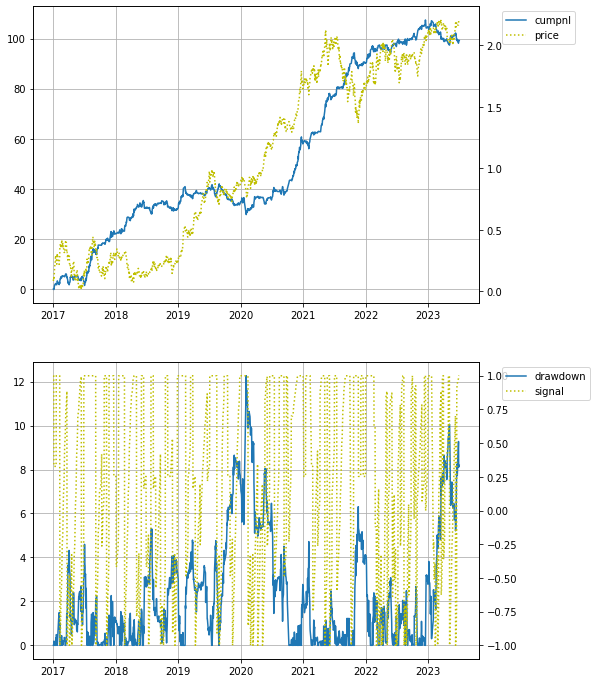

signal=strip_hsec_lvl_mid
sharpe       1.344076
sharpe_6m    1.595950
sharpe_1y    1.069037
sharpe_2y    1.158388
sharpe_3y    1.727084
sharpe_4y    1.509399
sharpe_5y    1.371592
sharpe_6y    1.331985
sharpe_7y    1.344076
sharpe_8y    1.344076
sharpe_9y    1.344076
Name: total, dtype: float64
std       0.516182
std_6m    0.510580
std_1y    0.560082
std_2y    0.541089
std_3y    0.550985
std_4y    0.526833
std_5y    0.522670
std_6y    0.518833
std_7y    0.516182
std_8y    0.516182
std_9y    0.516182
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.206511  1.230987  1.097268  0.990703  0.891568  0.695506   
sharpe_6m  1.905849  2.536427  1.957705  1.801314  1.533881  1.476900   
sharpe_1y  1.188647  1.431793  1.486965  1.454607  1.073850  0.633191   
sharpe_2y  0.689239  1.153611  1.411929  1.322228  1.093702  0.809601   
sharpe_3y  1.495891  1.652560  1.776280  1.487542  1.498118  0.747952   
sharpe_4y  1.177705  1.353854

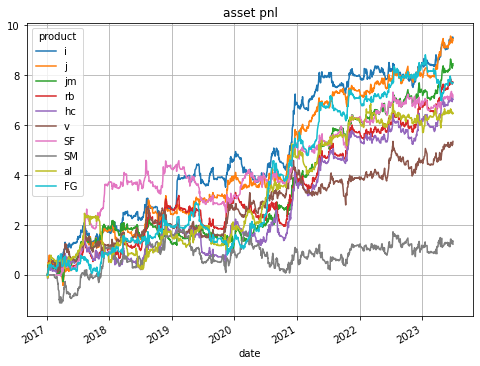

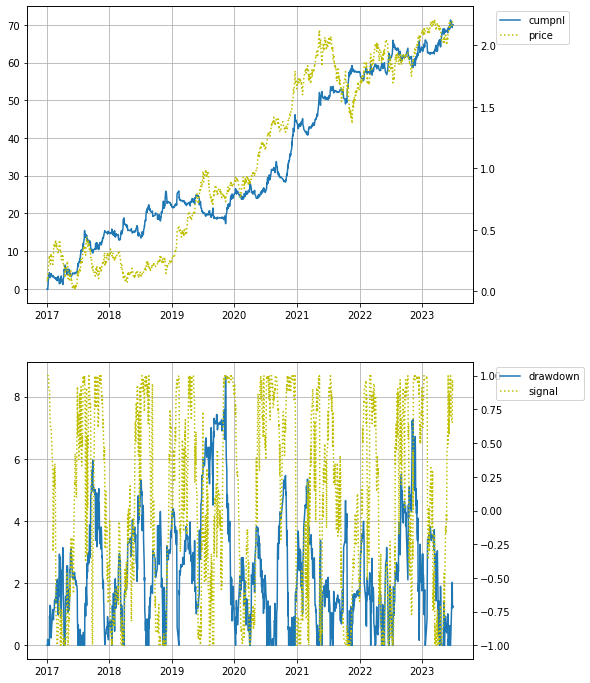

signal=steel_margin_lvl_fast
sharpe       1.556962
sharpe_6m   -1.221367
sharpe_1y    0.111474
sharpe_2y    0.390053
sharpe_3y    1.263825
sharpe_4y    1.469292
sharpe_5y    1.375953
sharpe_6y    1.544975
sharpe_7y    1.556962
sharpe_8y    1.556962
sharpe_9y    1.556962
Name: total, dtype: float64
std       0.533190
std_6m    0.496553
std_1y    0.524270
std_2y    0.542010
std_3y    0.560828
std_4y    0.547849
std_5y    0.536992
std_6y    0.532418
std_7y    0.533190
std_8y    0.533190
std_9y    0.533190
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     1.322395  1.666301  1.025903  0.974517  1.011155  1.053575   
sharpe_6m -0.043465 -0.501077 -0.790438 -0.982582 -1.273393 -2.159000   
sharpe_1y  0.976208  0.582921  0.343529  0.060392 -0.444947 -0.758841   
sharpe_2y  0.372373  1.219212  1.369748 -0.309394 -0.399457 -0.134720   
sharpe_3y  1.361445  1.416015  1.220266  0.793572  0.817892  0.231412   
sharpe_4y  1.611312  1.560

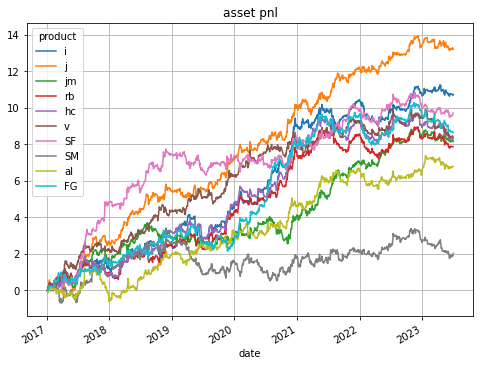

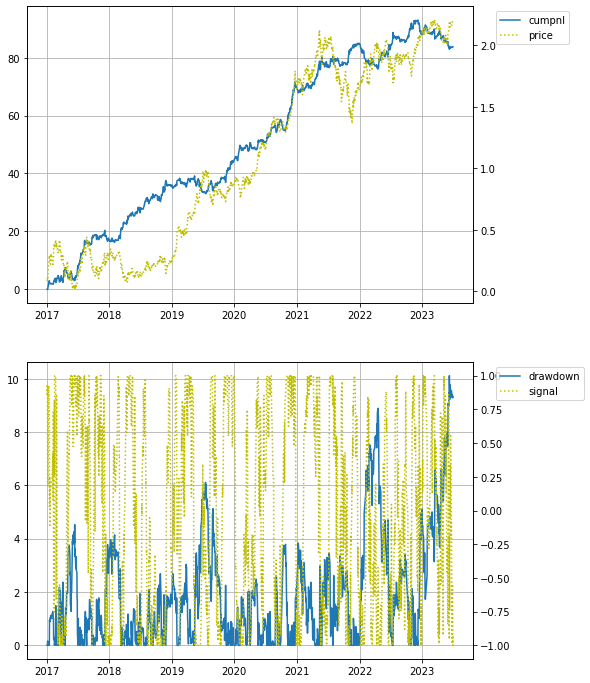

signal=combo
sharpe       2.763239
sharpe_6m    2.165734
sharpe_1y    2.229616
sharpe_2y    2.166595
sharpe_3y    3.121607
sharpe_4y    2.861436
sharpe_5y    2.654954
sharpe_6y    2.811809
sharpe_7y    2.763239
sharpe_8y    2.763239
sharpe_9y    2.763239
Name: total, dtype: float64
std       2.062106
std_6m    2.088591
std_1y    2.395759
std_2y    2.059914
std_3y    2.153262
std_4y    2.037359
std_5y    1.985197
std_6y    2.091971
std_7y    2.062106
std_8y    2.062106
std_9y    2.062106
Name: total, dtype: float64
product           i         j        jm        rb        hc         v  \
sharpe     2.454530  2.230122  1.747495  2.108912  2.280228  1.832159   
sharpe_6m  1.925767  3.397792  2.443474  2.876629  2.604506  1.625141   
sharpe_1y  2.054268  2.478591  2.323368  2.397605  1.995091  2.024138   
sharpe_2y  1.626002  2.001398  1.948480  2.007446  1.736011  1.951415   
sharpe_3y  2.956553  2.322248  1.997400  2.513590  2.650655  2.099929   
sharpe_4y  2.463838  1.943804  1.627495  2

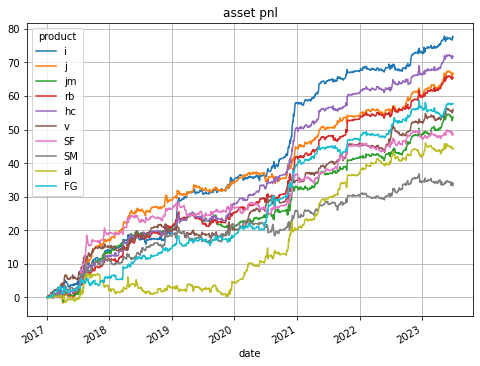

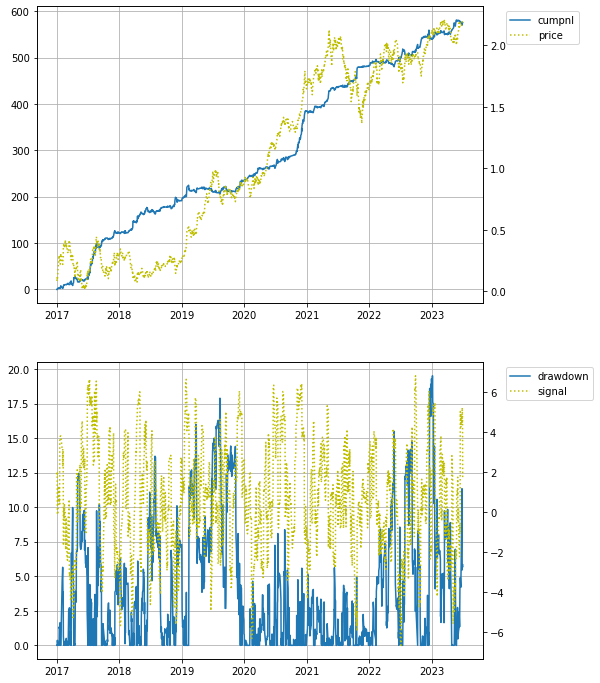

corr:
                       io_removal_lvl  io_removal_lyoy  io_millinv_lyoy  \
io_removal_lvl               1.000000         0.548003         0.116010   
io_removal_lyoy              0.548003         1.000000         0.191429   
io_millinv_lyoy              0.116010         0.191429         1.000000   
io_invdays_lyoy              0.039592         0.076182         0.477312   
io_invdays_lvl               0.142752        -0.021460         0.125001   
strip_hsec_lvl_mid           0.148243         0.036496         0.031745   
steel_margin_lvl_fast       -0.048559         0.008394         0.086230   

                       io_invdays_lyoy  io_invdays_lvl  strip_hsec_lvl_mid  \
io_removal_lvl                0.039592        0.142752            0.148243   
io_removal_lyoy               0.076182       -0.021460            0.036496   
io_millinv_lyoy               0.477312        0.125001            0.031745   
io_invdays_lyoy               1.000000        0.478481            0.089780   
io_

In [49]:
pnl_df = pd.DataFrame(index=df_pxchg.index)
for signal_name in signal_dict:
    signal_ts = signal_dict[signal_name]
    signal_ts = signal_ts.reindex(index=cdates).ffill().reindex(index=df_pxchg.index).dropna()[cutoff:]
    signal_df = pd.DataFrame(dict([(asset, signal_ts.shift(1)) for asset in empiric_assets]))
    holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1.0, asset_scaling=False)
    bt_metrics = MetricsBase(holdings=holding[empiric_assets][cutoff:],
                             returns=df_pxchg[empiric_assets][cutoff:])

    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])

    print("signal=%s\n%s\n%s" % (signal_name, pnl_stats['sharpe'], pnl_stats['std']))
    print(pnl_stats['asset_sharpe_stats'])
    print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))

    pnl_df[signal_name] = pnl_stats['portfolio_pnl']['total']
    
    pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
    plt.grid()
    plt.title('asset pnl')

    plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_ts, asset_price=df_pxchg[empiric_assets[0]].cumsum(), figsize=(8, 12))

cutoff = '2017-01-01'
print('corr:\n%s\n' % pnl_df.drop(columns=['combo'])[cutoff:].corr())
print('std:\n%s\n' % pnl_df[cutoff:].std(axis=0))

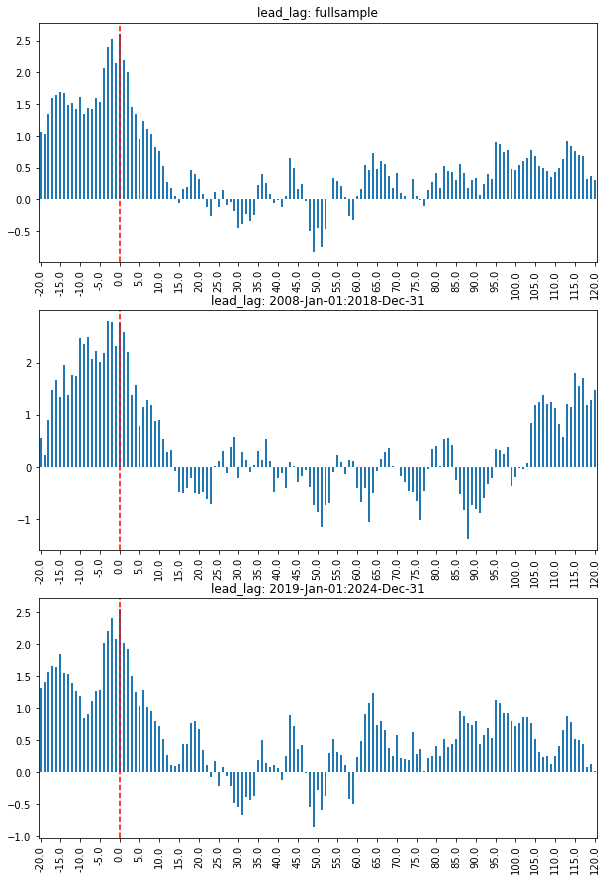

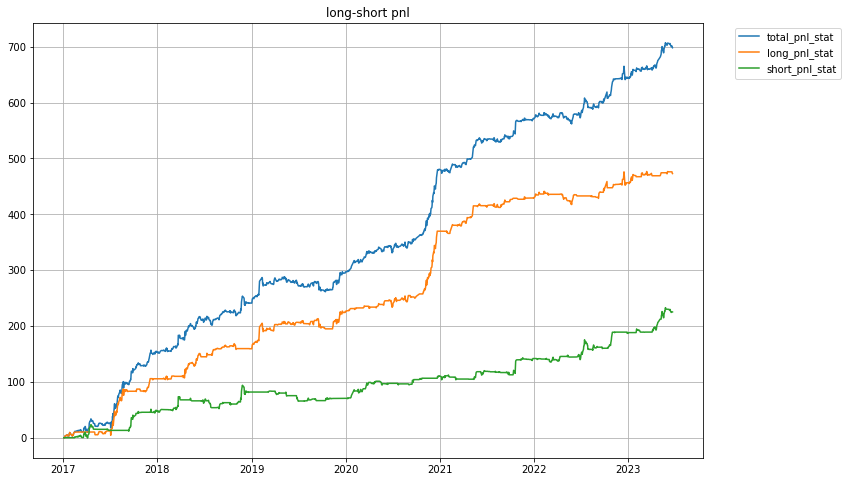

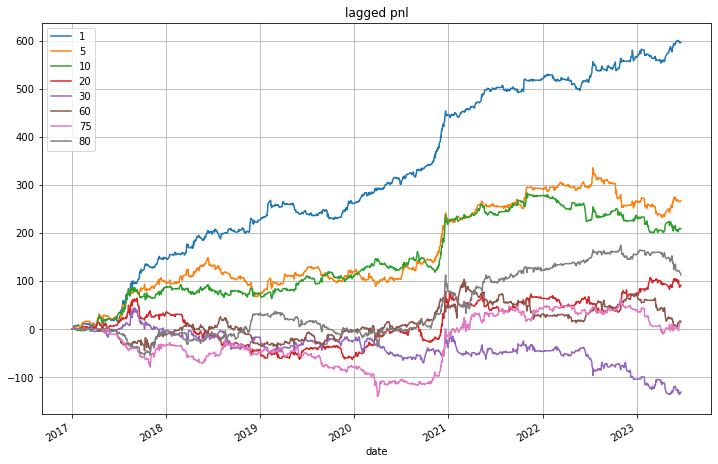

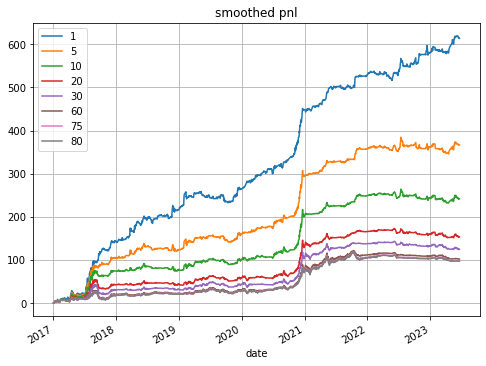

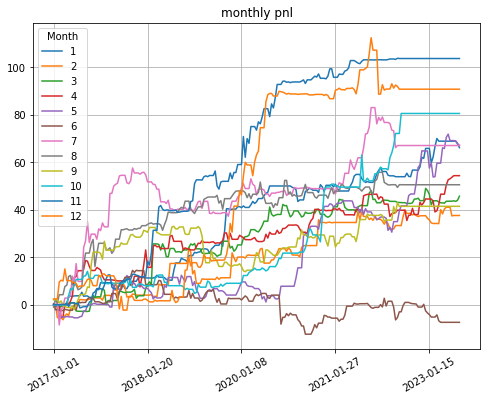

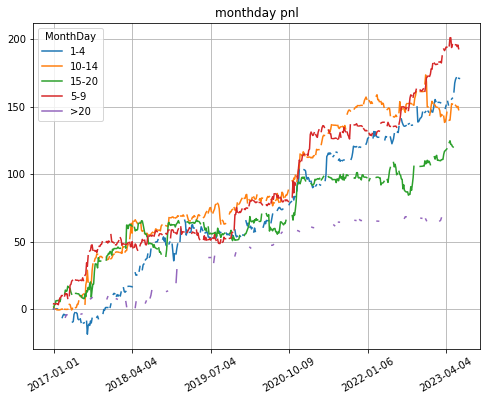

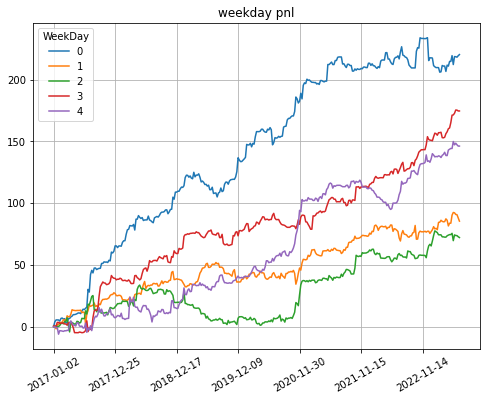

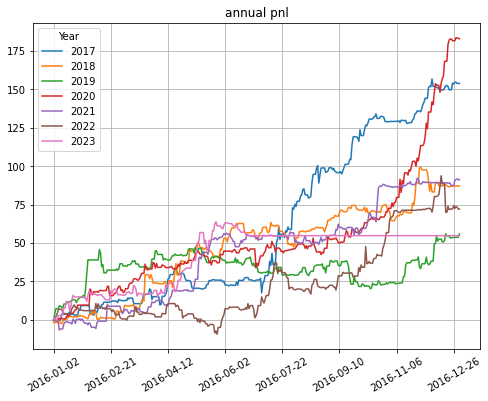

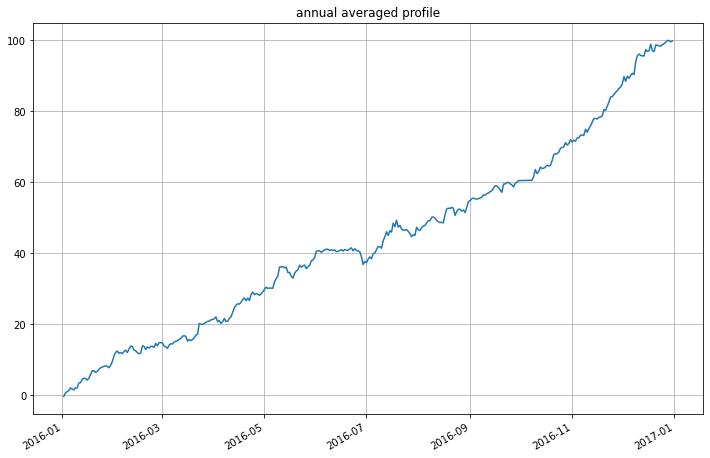

In [152]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2018, 12, 31)), 
                   (datetime.date(2019, 1, 1), datetime.date(2024, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = bt_metrics.lead_lag(ll_limit_left=ll_left, 
                                 ll_limit_right=ll_right,
                                 ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)
    ax[i].axvline(x=-ll_left, color='red', linestyle='--')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ls_pnl = bt_metrics.long_short_pnl()
for key in ls_pnl:
    ax.plot(ls_pnl[key]['portfolio_cumpnl'].index, ls_pnl[key]['portfolio_cumpnl'].values, '-', label=key)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, bbox_to_anchor=(1.04, 1), loc='upper left')
ax.grid()
plt.title("long-short pnl")
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
#print('lagged PNL\n', lagged['sharpe'])
plt.grid()
plt.title('lagged pnl')
plt.show()

smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(8, 6))
#print('smoothed PNL\n', smoothed['sharpe'])
plt.grid()
plt.title('smoothed pnl')
plt.show()

#tilt_timing = bt_metrics.tilt_timing(tilt_rolling_window=1*244) # default 3 years  tilt_rolling_window = 3 * 244 

seasonal_pnl = bt_metrics.seasonal_pnl()
cumpnl = seasonal_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('seasonal sharpe stats\n', seasonal_pnl['sharpe_stats'])
plt.grid()
plt.title('monthly pnl')
plt.show()


monthday_pnl = bt_metrics.monthday_pnl()
cumpnl = monthday_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('monthday sharpe stats\n', monthday_pnl['sharpe_stats'])
plt.grid()
plt.title('monthday pnl')
plt.show()


week_pnl = bt_metrics.week_pnl()
cumpnl = week_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('week sharpe stats\n', week_pnl['sharpe_stats'])
plt.grid()
plt.title('weekday pnl')
plt.show()


annual_pnl = bt_metrics.annual_pnl()
cumpnl = annual_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('annual sharpe stats\n', annual_pnl['sharpe_stats'])
plt.grid()
plt.title('annual pnl')
plt.show()

annual_pnl['cumlog_pnl'].mean(axis=1).plot()
plt.grid()
plt.title('annual averaged profile')
plt.show()

# turnover = bt_metrics.turnover()
# print(turnover)

# batch feature exploration

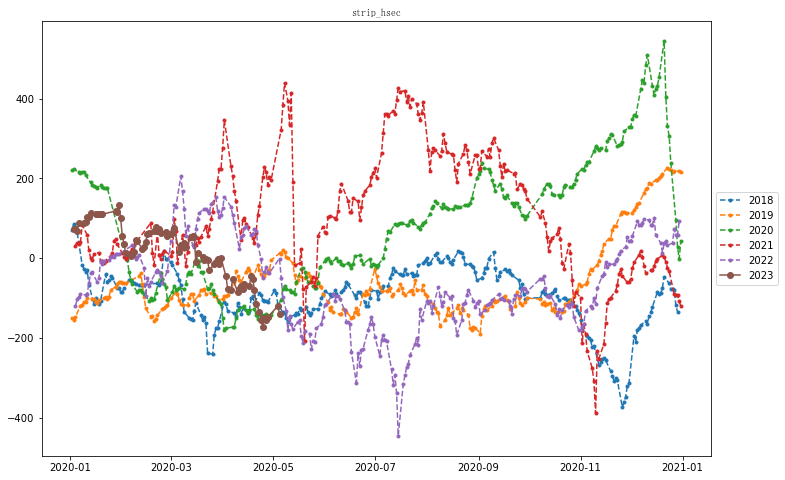

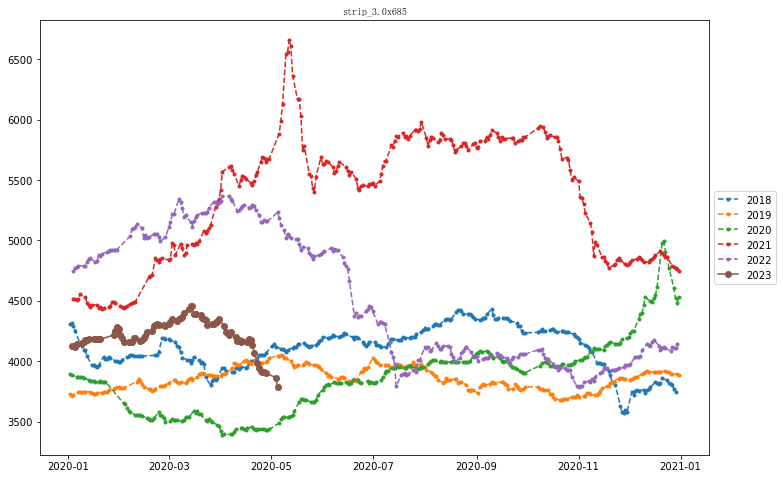

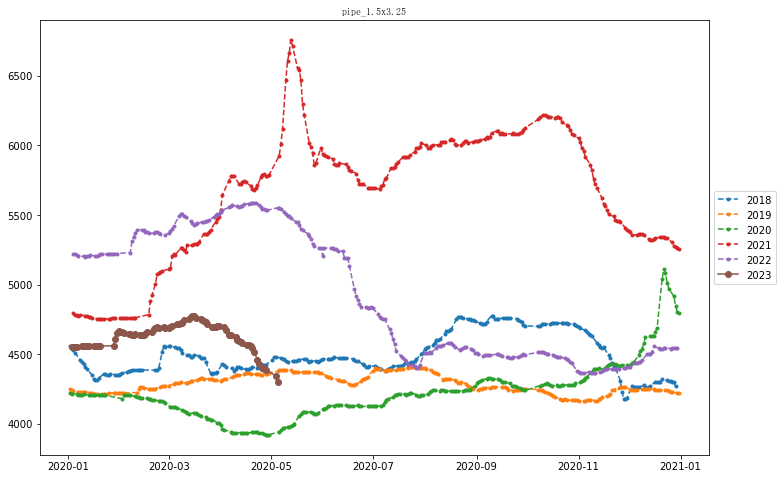

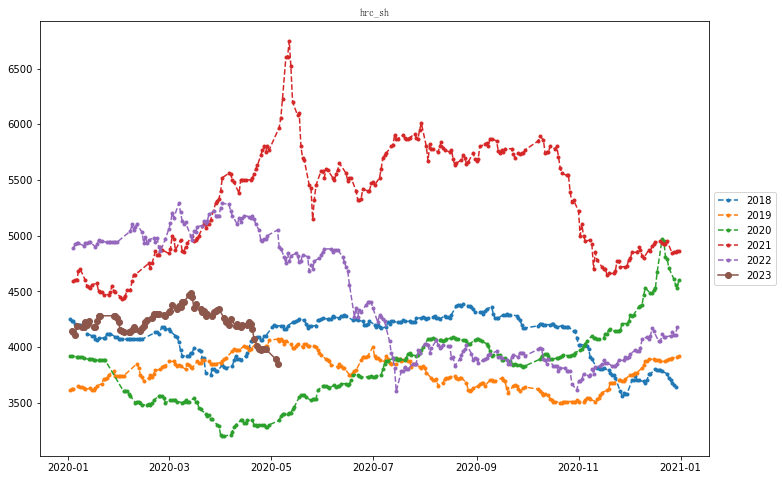

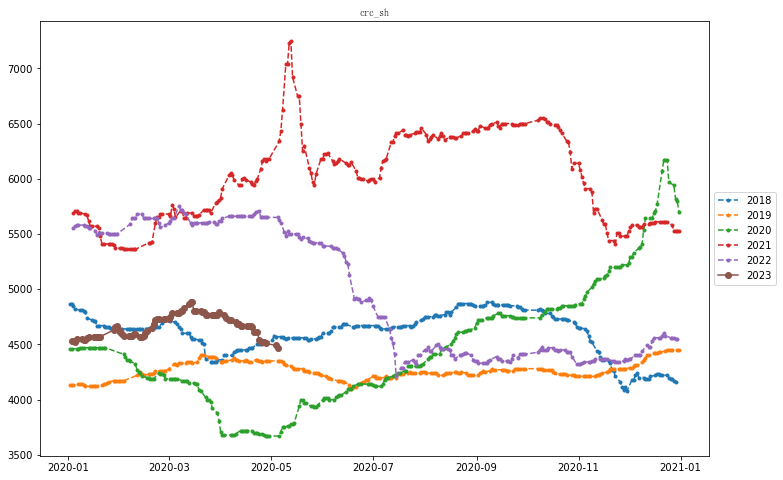

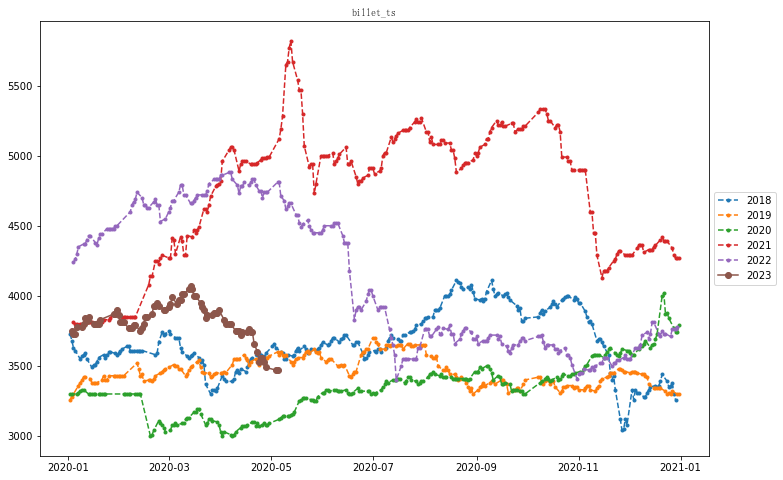

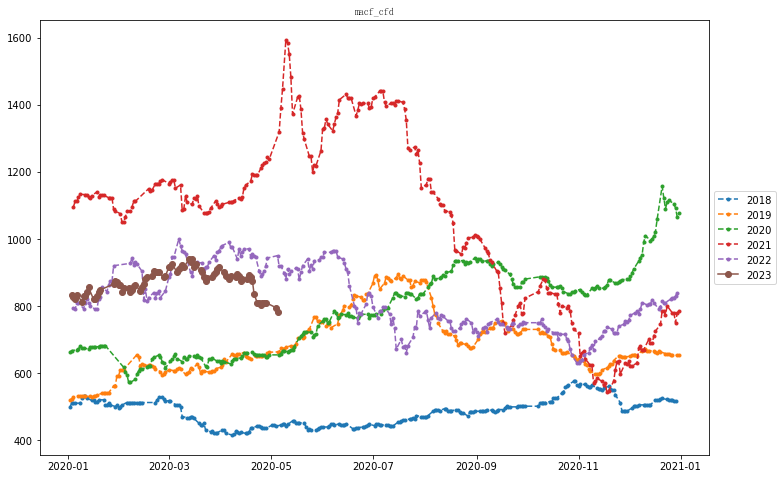

In [116]:
feature_list = [
#     'margin_hrc_sh', 
    'strip_hsec',
    'strip_3.0x685',
    'pipe_1.5x3.25',    
    'hrc_sh',
    'crc_sh',
    'billet_ts',
    'macf_cfd',
#     'gi_0.5_sh',
#     'hsec_400x200',
#     'highwire_6.5',
#     'angle_50x5',
#     'ibeam_25',
#     'channel_16',

#     'import_arb', 'pbf_prem', 'plt65_62',
#     'io_laytime_45ports', 'io_inv_imp_31ports',
#     'io_invdays_imp_mill(64)', 'io_inv_mill(64)', 'io_inv_imp_mill',
#     'io_removal_port_41',
#     'io_loading_14ports_ausbzl',
]

udf = spot_df[feature_list].dropna(how='all')
# lunar_seasonal = True

# if lunar_seasonal:
#     seasonal_signal = tstool.lunar_label(udf)
#     seasonal_signal = tstool.seasonal_group_score(
#         seasonal_signal, score_cols=feature_list, yr_col='lunar_cny',
#         group_col='lunar_wks', min_obs=3, backward=2, forward=2, rolling_years=3)
#     seasonal_signal = seasonal_signal.reindex(index=df.index).ffill()

for feature in udf.columns:
    dataseries.plot_seasonal_df(udf[feature].dropna(), cutoff='2018-01-01', title=feature)
    
signal_raw = udf[feature_list].reindex(index=df.index).ffill()


rb:strip_hsec -> SR: 1.00 -- PNL per trade: 33.08 -- Turnover: 26.72
rb:strip_3.0x685 -> SR: 1.07 -- PNL per trade: 55.20 -- Turnover: 17.46
rb:pipe_1.5x3.25 -> SR: 0.85 -- PNL per trade: 53.25 -- Turnover: 14.26
rb:hrc_sh -> SR: 1.11 -- PNL per trade: 46.67 -- Turnover: 21.92
rb:crc_sh -> SR: 1.03 -- PNL per trade: 60.39 -- Turnover: 15.17
rb:billet_ts -> SR: 0.85 -- PNL per trade: 30.21 -- Turnover: 26.18
rb:macf_cfd -> SR: 1.18 -- PNL per trade: 77.03 -- Turnover: 13.00


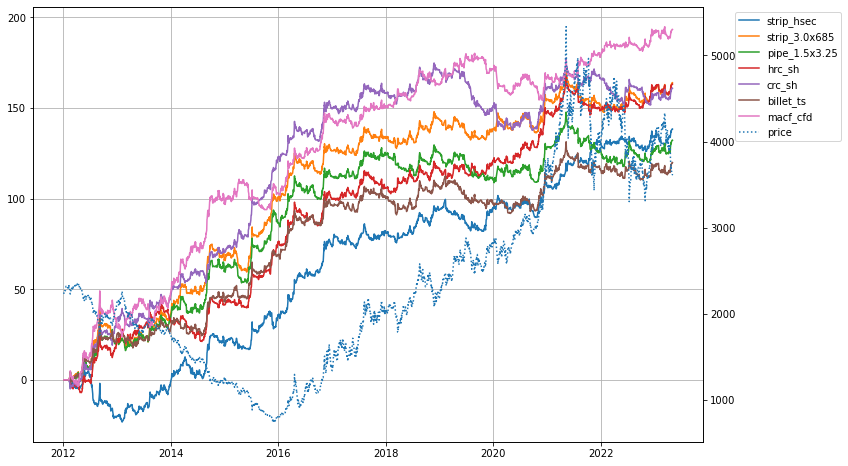

hc:strip_hsec -> SR: 1.25 -- PNL per trade: 42.52 -- Turnover: 28.27
hc:strip_3.0x685 -> SR: 0.96 -- PNL per trade: 49.43 -- Turnover: 19.23
hc:pipe_1.5x3.25 -> SR: 0.72 -- PNL per trade: 49.98 -- Turnover: 13.95
hc:hrc_sh -> SR: 1.26 -- PNL per trade: 54.48 -- Turnover: 23.52
hc:crc_sh -> SR: 0.87 -- PNL per trade: 53.23 -- Turnover: 16.00
hc:billet_ts -> SR: 0.71 -- PNL per trade: 27.15 -- Turnover: 26.33
hc:macf_cfd -> SR: 0.89 -- PNL per trade: 48.24 -- Turnover: 17.91


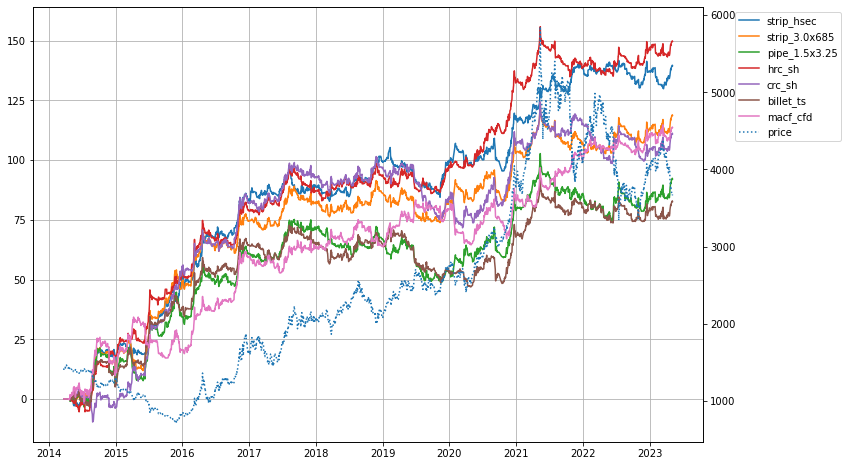

i:strip_hsec -> SR: 1.37 -- PNL per trade: 74.96 -- Turnover: 26.70
i:strip_3.0x685 -> SR: 1.02 -- PNL per trade: 81.14 -- Turnover: 18.90
i:pipe_1.5x3.25 -> SR: 0.76 -- PNL per trade: 79.20 -- Turnover: 14.08
i:hrc_sh -> SR: 1.05 -- PNL per trade: 70.10 -- Turnover: 23.09
i:crc_sh -> SR: 0.73 -- PNL per trade: 67.10 -- Turnover: 16.17
i:billet_ts -> SR: 0.85 -- PNL per trade: 49.90 -- Turnover: 26.78
i:macf_cfd -> SR: 1.52 -- PNL per trade: 132.16 -- Turnover: 16.51


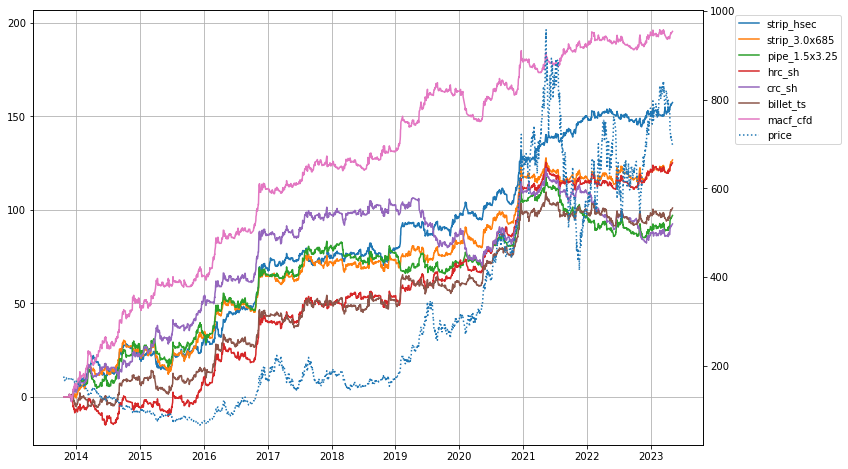

j:strip_hsec -> SR: 1.26 -- PNL per trade: 53.79 -- Turnover: 27.92
j:strip_3.0x685 -> SR: 1.37 -- PNL per trade: 89.78 -- Turnover: 17.88
j:pipe_1.5x3.25 -> SR: 1.49 -- PNL per trade: 121.06 -- Turnover: 14.14
j:hrc_sh -> SR: 1.07 -- PNL per trade: 59.06 -- Turnover: 22.09
j:crc_sh -> SR: 1.50 -- PNL per trade: 115.20 -- Turnover: 15.14
j:billet_ts -> SR: 1.23 -- PNL per trade: 56.59 -- Turnover: 26.66
j:macf_cfd -> SR: 1.32 -- PNL per trade: 109.48 -- Turnover: 13.21


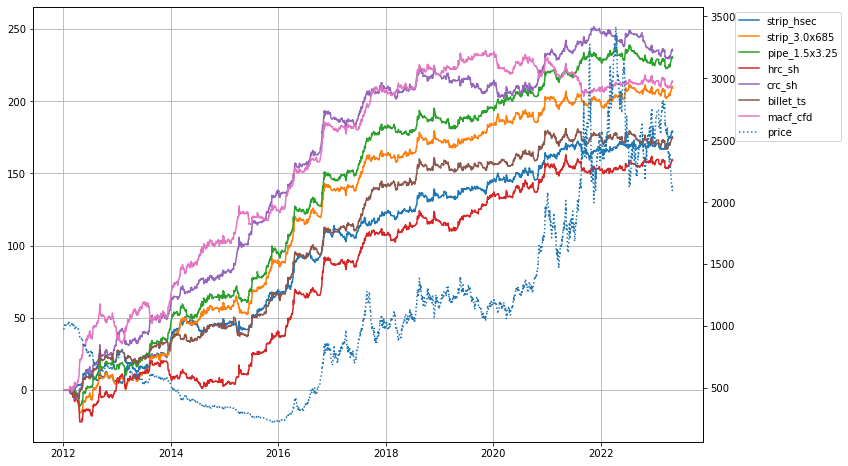

jm:strip_hsec -> SR: 1.11 -- PNL per trade: 47.05 -- Turnover: 27.42
jm:strip_3.0x685 -> SR: 1.10 -- PNL per trade: 69.23 -- Turnover: 18.61
jm:pipe_1.5x3.25 -> SR: 1.11 -- PNL per trade: 91.50 -- Turnover: 13.80
jm:hrc_sh -> SR: 0.74 -- PNL per trade: 38.50 -- Turnover: 23.06
jm:crc_sh -> SR: 1.26 -- PNL per trade: 93.10 -- Turnover: 15.35
jm:billet_ts -> SR: 0.85 -- PNL per trade: 37.64 -- Turnover: 27.50
jm:macf_cfd -> SR: 0.93 -- PNL per trade: 65.74 -- Turnover: 15.77


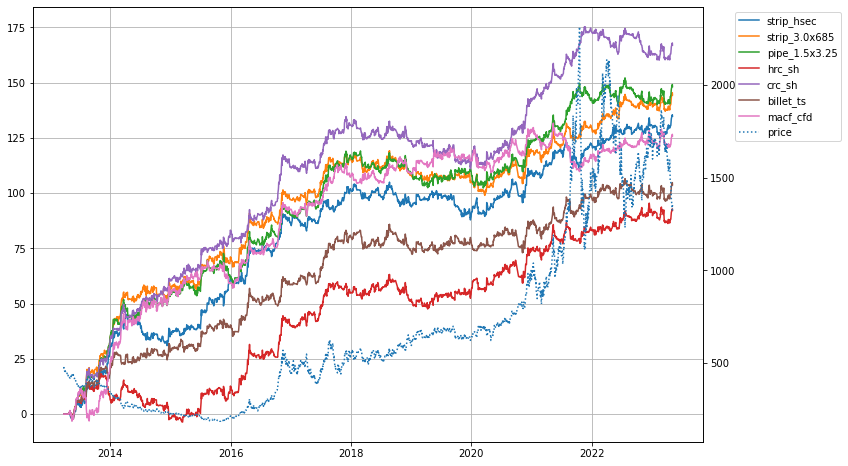

SF:strip_hsec -> SR: 0.18 -- PNL per trade: 6.28 -- Turnover: 30.83
SF:strip_3.0x685 -> SR: 0.70 -- PNL per trade: 35.25 -- Turnover: 21.70
SF:pipe_1.5x3.25 -> SR: 0.89 -- PNL per trade: 61.14 -- Turnover: 15.48
SF:hrc_sh -> SR: 0.94 -- PNL per trade: 42.61 -- Turnover: 24.70
SF:crc_sh -> SR: 1.28 -- PNL per trade: 86.06 -- Turnover: 15.70
SF:billet_ts -> SR: 0.69 -- PNL per trade: 28.08 -- Turnover: 27.31
SF:macf_cfd -> SR: 0.66 -- PNL per trade: 31.76 -- Turnover: 22.86


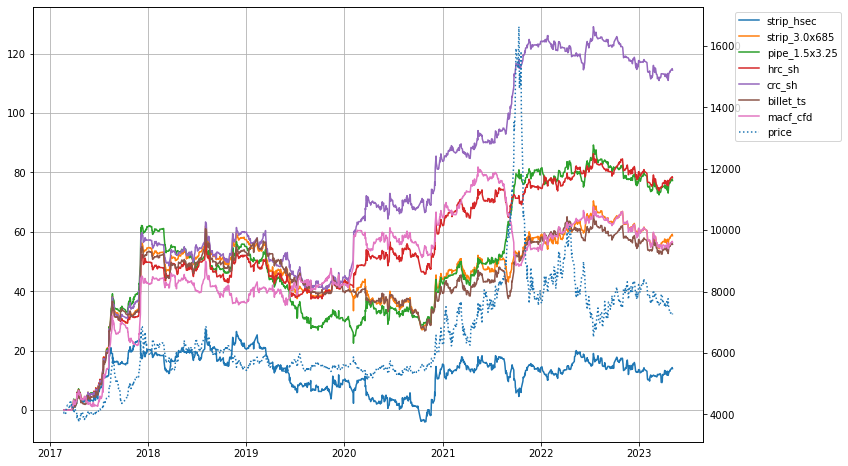

FG:strip_hsec -> SR: 1.09 -- PNL per trade: 38.09 -- Turnover: 29.64
FG:strip_3.0x685 -> SR: 0.48 -- PNL per trade: 25.14 -- Turnover: 20.07
FG:pipe_1.5x3.25 -> SR: 0.31 -- PNL per trade: 21.01 -- Turnover: 14.80
FG:hrc_sh -> SR: 0.87 -- PNL per trade: 38.18 -- Turnover: 23.47
FG:crc_sh -> SR: 0.40 -- PNL per trade: 24.92 -- Turnover: 16.19
FG:billet_ts -> SR: 0.76 -- PNL per trade: 29.74 -- Turnover: 26.37
FG:macf_cfd -> SR: 0.65 -- PNL per trade: 33.69 -- Turnover: 19.86


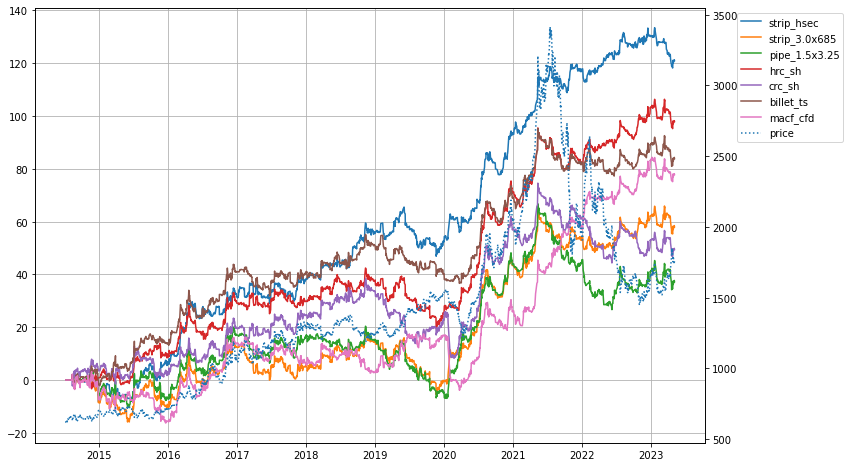

In [118]:
cutoff = '2012-01-01'
signal_func = 'qtl'
param_rng = [20, 42, 2]
signal_cap = None # [-2, 2]
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'SF', 'FG', ] # 'v', 'cu', 'al', 'ss', 'UR', 'SA', 'ru'

for asset in product_list:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')[cutoff:]
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')[cutoff:]
    pnl_list = [price_ts]
    for feature in feature_list:
        feature_ts = udf[feature].reindex(index=price_ts.index).ffill()
        #feature_ts = feature_ts.pct_change(5)
        #feature_ts = tstool.lunar_yoy(feature_ts, group_col='lunar_days', func='pct_change')
        #feature_ts = tstool.seasonal_score(feature_ts.to_frame())
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].cumsum().to_frame(feature))
    pnl_df = pd.concat(pnl_list, axis=1)
    dataseries.plot_df_on_2ax(pnl_df, left_on=feature_list, right_on=['price'])
    

# signal grid search run

In [ ]:
signal_list = []

for feature in feature_list:
    for win in [20, 40, 60, 80, 120, 240]:
        signal_name = f"{feature}:ma:{win}"
        signal_raw[signal_name] = signal_raw[feature] - signal_raw[feature].rolling(win).mean()
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:ewmac:{win}"
        signal_raw[signal_name] = dh.ewmac(signal_raw[feature], win_s=win/10, ls_ratio=2)
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)

#         signal_name = f"{feature}:convewm:{win}"
#         signal_raw[signal_name] = dh.conv_ewm(signal_raw[feature], h1s=[win//10, win//10*2], h2s=[win//10*3, win//10*6])
#         signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)
        
        signal_name = f"{feature}:zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:zscore_dff20:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature].diff(20), win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl_dff20:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature].diff(20), win=win)*2
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:lunar_wks_score:{win}"
        signal_raw[signal_name] = seasonal_signal[feature]
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:seasonal_score"
        signal_raw[signal_prefix] = tstool.seasonal_score(signal_raw[feature].to_frame())
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:yoy"
        signal_raw[signal_prefix] = signal_raw[feature]/signal_raw[feature].shift(244)-1
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)

        signal_prefix = f"{feature}:lunar_yoy"
        signal_raw[signal_prefix] = tstool.lunar_yoy(signal_raw[feature], group_col='lunar_days', func='pct_change')
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
signal_raw = signal_raw.reindex(index=df.index).ffill()

In [ ]:
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'v', 'FG', 'SM', 'SF']
cutoff = pd.Timestamp('2012-07-01')

for sig in signal_list:
    print(sig)
    pnl_by_asset = {}
    pnl_df = pd.DataFrame()
    pos_df = pd.DataFrame()
    for asset in product_list:
        signal = signal_raw[sig]
        asset_df = pd.concat([df[(asset, 'c1', 'close')], signal], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price']).ffill()
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        
        pnl_by_asset[asset] = asset_df
        pnl_df[asset] = asset_df['pnl']
        pos_df[asset] = asset_df['position']
    pnl_df = pnl_df.fillna(0)
    pos_df = pos_df.ffill()
    total_sr = = np.sqrt(244) * pnl_df.sum(axis=1).mean()/pnl_df.sum(axis=1).std()
    print(f'Total SR: {total_sr:.2f}')
    
    cumpn; = pnl_df.cumsum()
    cumpnl.plot()
    plt.title(sig)
    plt.show()
    cum_pnl.sum(axis=1).plot()
    plt.title(sig)
    plt.show()
    

# Signal portfolio

In [111]:
signal_dict_full = {
    'i': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 0.5),
        #('io_inv_mill(64)_lyoy_mom', 0.5),
        
        ('io_invdays_imp_mill(64)_lvl_fast', 0.5),
        #('io_invdays_imp_mill(64)_lyoy_mom', 0.5),
        
#         ('steel_social_inv_lvl_fast', 1.0/1.0),
#         ('rebar_inv_social_lyoy_fast', 0.25/1.0),
#         ('wirerod_inv_social_lyoy_fast', 0.25/1.0),
#         ('hrc_inv_social_lyoy_fast', 0.25/1.0),
#         ('crc_inv_social_lyoy_fast', 0.25/1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),
        ('macf_cfd_lvl_mid', 1.0),
#         ('pbf_prem_yoy', 0.5/15),
#         ('cons_steel_lyoy_slow', 1.0/1.5),
#         ('sea_export_arb_lvl_mid', 1.0/1.4),
    ],
    'rb': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('rebar_inv_social_lyoy_fast', 1.0),
#         ('wirerod_inv_social_lyoy_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'hc': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('hrc_inv_social_lyoy_fast', 1.0),
#         ('crc_inv_social_lyoy_fast', 1.0),        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),  
    ],
    'j': [
        #('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'jm': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),     
    ],
    'FG': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
}

i:io_removal_lvl_fast -> SR: 1.44 -- PNL per trade: 125.18 -- Turnover: 16.32
i:io_inv_mill(64)_lvl_fast -> SR: 1.06 -- PNL per trade: 124.63 -- Turnover: 12.02
i:io_invdays_imp_mill(64)_lvl_fast -> SR: 1.08 -- PNL per trade: 96.53 -- Turnover: 16.77
i:margin_lvl_fast -> SR: 1.41 -- PNL per trade: 98.64 -- Turnover: 20.34
i:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 101.73 -- Turnover: 19.64
i:macf_cfd_lvl_mid -> SR: 1.24 -- PNL per trade: 150.45 -- Turnover: 12.07
i:total -> SR: 1.92 -- PNL per trade: 173.72 -- Turnover: 17.79
io_removal_lvl_fast                 0.829607
io_inv_mill(64)_lvl_fast            0.438992
io_invdays_imp_mill(64)_lvl_fast    0.402572
margin_lvl_fast                     0.849863
strip_hsec_lvl_mid                  0.776010
macf_cfd_lvl_mid                    0.864912
dtype: float64


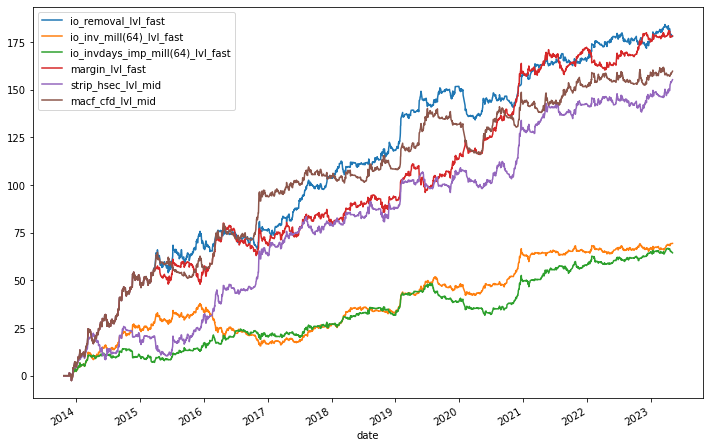

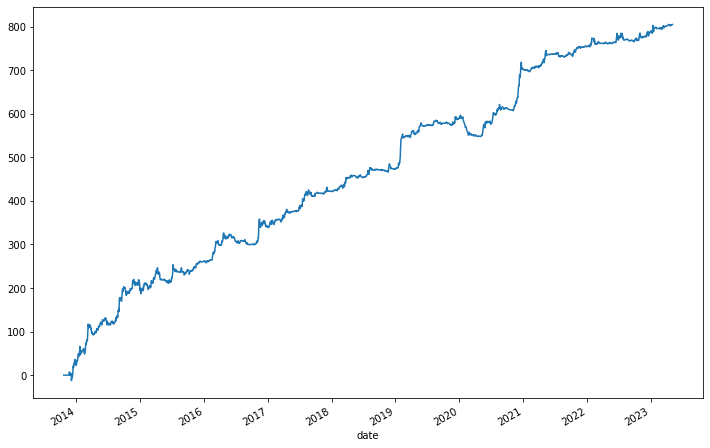

rb:io_removal_lvl_fast -> SR: 1.14 -- PNL per trade: 82.35 -- Turnover: 10.73
rb:io_inv_mill(64)_lvl_fast -> SR: 0.90 -- PNL per trade: 81.30 -- Turnover: 8.63
rb:margin_lvl_fast -> SR: 1.13 -- PNL per trade: 67.99 -- Turnover: 12.88
rb:strip_hsec_lvl_mid -> SR: 0.88 -- PNL per trade: 39.16 -- Turnover: 19.54
rb:total -> SR: 1.30 -- PNL per trade: 87.76 -- Turnover: 12.28
io_removal_lvl_fast         0.941461
io_inv_mill(64)_lvl_fast    0.974576
margin_lvl_fast             0.951824
strip_hsec_lvl_mid          0.813721
dtype: float64


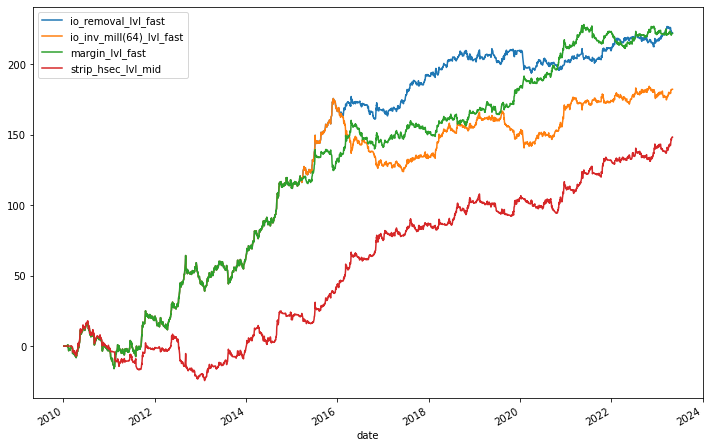

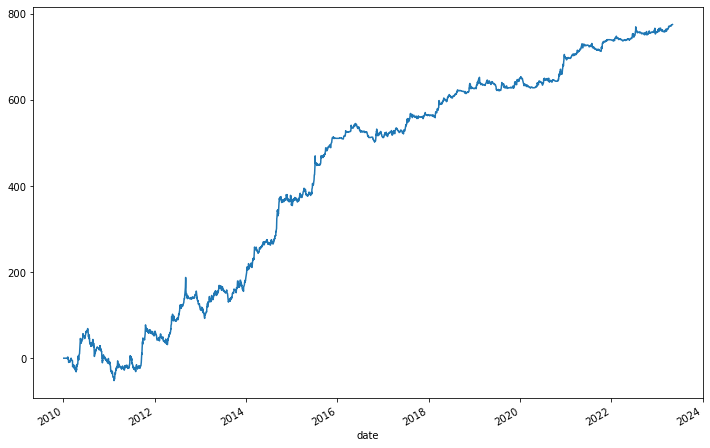

hc:io_removal_lvl_fast -> SR: 1.11 -- PNL per trade: 59.73 -- Turnover: 17.62
hc:io_inv_mill(64)_lvl_fast -> SR: 0.77 -- PNL per trade: 55.45 -- Turnover: 13.05
hc:margin_lvl_fast -> SR: 1.10 -- PNL per trade: 47.66 -- Turnover: 22.04
hc:strip_hsec_lvl_mid -> SR: 1.34 -- PNL per trade: 62.48 -- Turnover: 21.46
hc:total -> SR: 1.54 -- PNL per trade: 78.61 -- Turnover: 20.48
io_removal_lvl_fast         0.852830
io_inv_mill(64)_lvl_fast    0.902805
margin_lvl_fast             0.871381
strip_hsec_lvl_mid          0.780406
dtype: float64


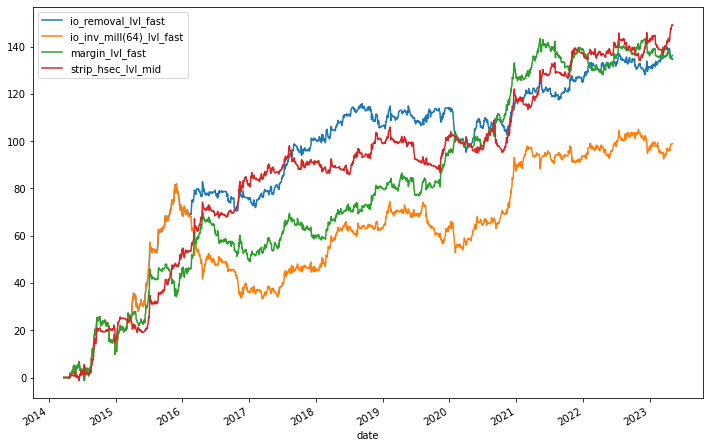

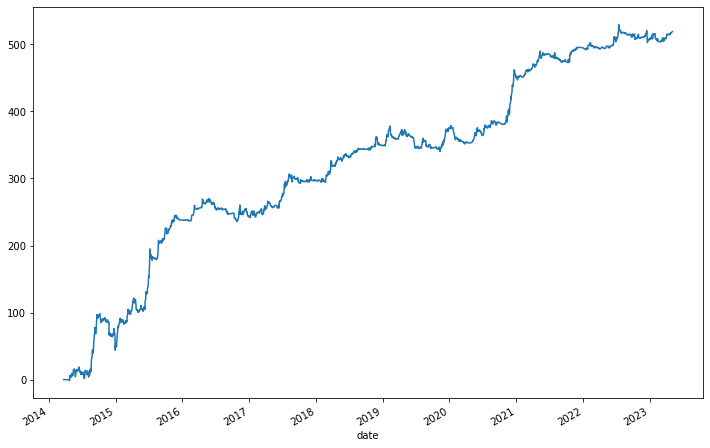

j:margin_lvl_fast -> SR: 1.72 -- PNL per trade: 123.09 -- Turnover: 14.65
j:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 71.61 -- Turnover: 21.87
j:total -> SR: 1.84 -- PNL per trade: 111.75 -- Turnover: 20.35
margin_lvl_fast       0.940847
strip_hsec_lvl_mid    0.792106
dtype: float64


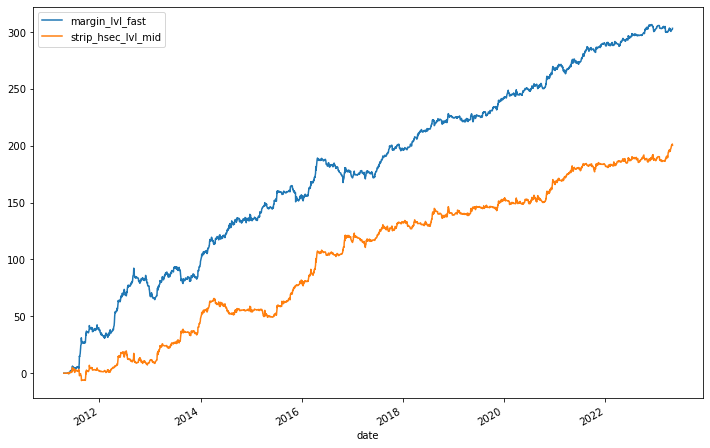

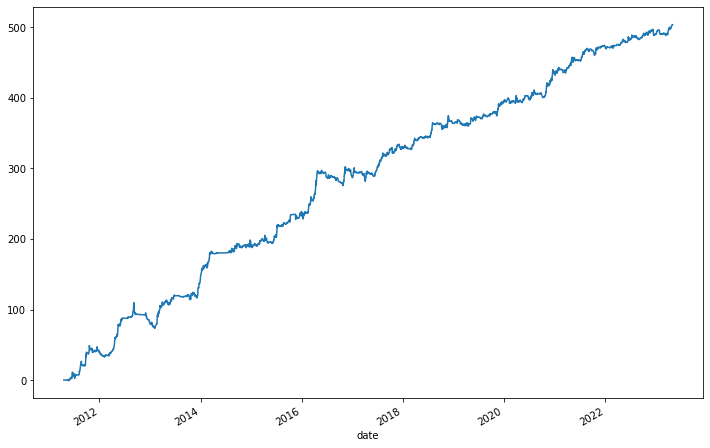

jm:margin_lvl_fast -> SR: 1.19 -- PNL per trade: 70.76 -- Turnover: 18.68
jm:strip_hsec_lvl_mid -> SR: 1.32 -- PNL per trade: 76.23 -- Turnover: 20.36
jm:total -> SR: 1.48 -- PNL per trade: 84.74 -- Turnover: 21.66
margin_lvl_fast       0.854962
strip_hsec_lvl_mid    0.761956
dtype: float64


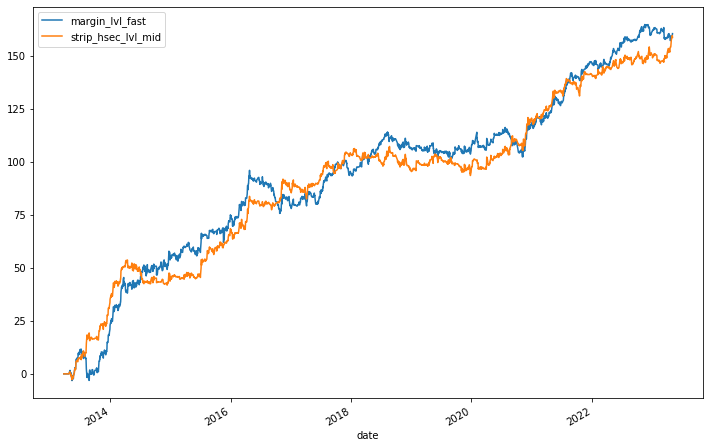

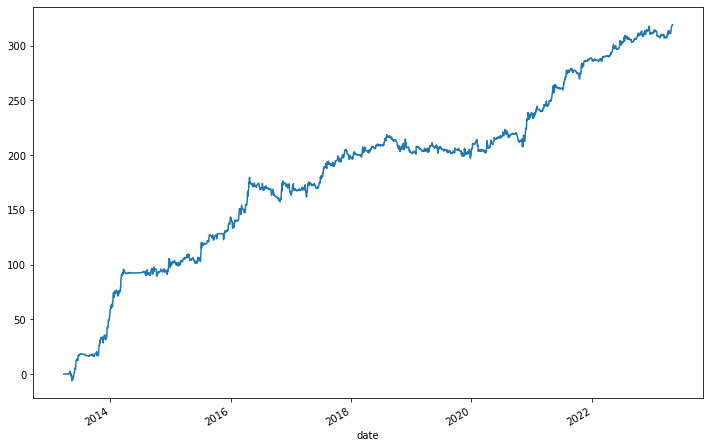

In [112]:
signal_dict = signal_dict_full

signal_diagnosis = False

pnl_dict = {}
pos_dict = {}

for asset in ['i', 'rb', 'hc', 'j', 'jm']:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')
    pnl_list = []
    pos_list = []
    for idx, (feature_name, weight) in enumerate(signal_dict[asset]):
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = signal_repo[feature_name]
        if freq == 'price':
            feature_ts = spot_df[feature].ffill().reindex(index=price_ts.index).ffill()
        elif len(freq) > 0:
            feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill()
        else:
            feature_ts = spot_df[feature].dropna()
        
        if 'yoy' in proc_func:
            if 'lunar' in proc_func:
                label_func = lunar_label
                label_args = {}
            else:
                label_func = calendar_label
                label_args = {'anchor_date': {'month': 1, 'day': 1}}
            if '_wk' in proc_func:
                group_col = 'label_wk'
            else:
                group_col = 'label_day'
            feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
        elif 'df' in proc_func:
            n_diff = int(proc_func[2:])
            feature_ts = getattr(feature_ts, chg_func)(n_diff)
    
        if signal_func == 'seasonal_score_w':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
        elif signal_func == 'seasonal_score_d':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
        elif len(signal_func)>0:
            feature_ts = feature_ts.reindex(index=df.index).ffill()
            signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        else:
            signal_ts = feature_ts.reindex(index=df.index).ffill()
            
        if not bullish:
            signal_ts = -signal_ts
            
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (weight*asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        std = asset_df['pnl'].std()
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature_name} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].to_frame(feature_name))
        pos_list.append(asset_df['position'].to_frame(feature_name))
        
    pnl_df = pd.concat(pnl_list, axis=1)
    pos_df = pd.concat(pos_list, axis=1)
    sum_pnl = pnl_df.sum(axis=1)
    sum_pos = pos_df.sum(axis=1)
    sr = np.sqrt(244) * sum_pnl.mean()/sum_pnl.std()
    pnl_per_trade = 100 * 100 * sum_pnl.mean()/sum_pos.diff().abs().mean()
    turnover = 100 * sum_pos.diff().abs().mean()/sum_pos.abs().mean()
    print(f'{asset}:total -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
    
    print(pnl_df.std())
    pnl_dict[asset] = pnl_df
    pos_dict[asset] = pos_df
    pnl_df.cumsum().plot()
    plt.show()
    sum_pnl.cumsum().plot()
    plt.show()


In [10]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = False
mean_win = 244
vol_win = 244
if demean:
    sig_scored = tstool.ts_score(sig_smooth, hl_mean=mean_win, min_obs_mean=mean_win, fill_backward_mean=fill_backward, 
                          hl_vol=vol_win, min_obs_vol=vol_win, fill_backward_vol=fill_backward)
else:
    sig_scored = tstool.ts_scale(sig_smooth, hl = vol_win, min_obs=vol_win, fill_backward=fill_backward)

#sig_scored = tstool.xs_score(sig_smooth, demean=demean, hl=vol_win)

signal_cap = 2.0

score_capped = tstool.cap(sig_scored, -signal_cap, signal_cap)
score_filled = tstool.filldown(score_capped, 2)
score = tstool.lag(score_filled, 1)


In [ ]:
vol_scale = 20
asset_vol = tstool.exp_smooth(df_pxchg**2, hl=vol_scale, fill_backward=fill_backward)**0.5
holding = score/asset_vol

commod_list = holding.columns #['hc']
btmetrics = MetricsBase(holdings = holding[commod_list], returns = df_pxchg[commod_list])